### 2. Grouping Users together!
Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

### 2.1 Getting your data + feature engineering
Access to the data found in this dataset

Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

- a) Favorite genre (i.e., the genre on which the user spent the most time)

- b) Average click duration

- c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

- d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

- e) Average time spent a day by the user (considering only the days he logs in)

So, in the end, you should have for each user_id five features.

Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).



### Getting Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("vodclickstream_uk_movies_03.csv")
df.shape

(671736, 8)

In [3]:
df_copy = df.copy()

In [4]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


In [6]:
print(df.apply(lambda col: col.nunique()))

Unnamed: 0      671736
datetime        624112
duration        104217
title             7925
genres            1190
release_date      3362
movie_id          8472
user_id         161918
dtype: int64


In [7]:
#### Convert datetime columns from string to datetime

df.datetime = pd.to_datetime(df.datetime)
df.release_date = pd.to_datetime(df.release_date, errors='coerce')

### Feature Engineering

- a) Favorite genre (i.e., the genre on which the user spent the most time) (Feature 1)

In [8]:
df['genre_list'] = df['genres'].str.split(', ')

In [9]:
# Explode the DataFrame based on the 'genre_list' column to have one row for each genre
exploded_df = df.explode('genre_list')

# Group by user and genre to calculate total time spent on each genre
user_genre_time = exploded_df.groupby(['user_id', 'genre_list'])['duration'].sum().reset_index()

# Find the favorite genre for each user (the genre they spent the most time on)
user_favorite_genre = user_genre_time.loc[user_genre_time.groupby('user_id')['duration'].idxmax()]

In [10]:
user_favorite_genre = user_favorite_genre[["user_id", "genre_list"]]

user_favorite_genre

,user_id,genre_list
0,00004e2862,Crime
3,000052a0a0,Action
17,000090e7c8,Mystery
20,000118a755,Horror
22,000296842d,Drama
...,...,...
861713,fffd9bf758,Crime
861716,fffe7b777b,Drama
861723,fffeac83be,Drama
861728,ffff2c5f9e,Action


- b) Average click duration (Feature 2)

In [11]:
# 1. Average Duration per User Interaction
user_avg_duration = df.groupby('user_id')['duration'].mean().reset_index()
user_avg_duration.columns = ['user_id', 'avg_duration']

In [12]:
user_avg_duration

,user_id,avg_duration
0,00004e2862,0.000000
1,000052a0a0,2024.166667
2,000090e7c8,0.000000
3,000118a755,-0.250000
4,000296842d,9663.375000
...,...,...
161913,fffd9bf758,8495.000000
161914,fffe7b777b,1785.000000
161915,fffeac83be,40606.272727
161916,ffff2c5f9e,0.000000


- c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks) (Feature 3)

In [13]:
df['time_of_day'] = df['datetime'].dt.hour.apply(lambda x: 'Morning' if 5 <= x < 12 else 'Afternoon' if 12 <= x < 18 else 'Night')
user_time_spent = df.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()

# Getting the index of maximum duration for each user
idx = user_time_spent.groupby('user_id')['duration'].idxmax()

# Selecting the time of day with the maximum duration for each user
user_most_time_spent = user_time_spent.loc[idx]

In [14]:
user_most_time_spent = user_most_time_spent[["user_id", "time_of_day"]]
user_most_time_spent

,user_id,time_of_day
0,00004e2862,Night
3,000052a0a0,Night
4,000090e7c8,Night
5,000118a755,Night
6,000296842d,Night
...,...,...
237446,fffd9bf758,Night
237447,fffe7b777b,Afternoon
237449,fffeac83be,Night
237450,ffff2c5f9e,Afternoon


- d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)? (Feature 4)

In [15]:
df['era'] = df['release_date'].dt.year.apply(lambda x: 'Old' if x < 2010 else 'New')

# Get unique movie counts for each user in each era
user_movie_counts = df.groupby(['user_id', 'era'])['movie_id'].nunique().unstack(fill_value=0)

# Determine user movie preferences
user_movie_counts['era_preference'] = user_movie_counts.apply(lambda row: 'Old' if row['Old'] > row['New'] else 'New', axis=1)

user_movie_counts = user_movie_counts['era_preference'].reset_index()

In [16]:
user_movie_counts

,user_id,era_preference
0,00004e2862,Old
1,000052a0a0,New
2,000090e7c8,New
3,000118a755,New
4,000296842d,New
...,...,...
161913,fffd9bf758,New
161914,fffe7b777b,New
161915,fffeac83be,New
161916,ffff2c5f9e,New


- e) Average time spent a day by the user (considering only the days he logs in) (Feature 5)

In [17]:
# Extract date from 'datetime'
df['date'] = df['datetime'].dt.date

# Group by user and date to calculate total time spent per day
user_daily_time = df.groupby(['user_id', 'date'])['duration'].sum().reset_index()

# Count the number of days each user logs in
user_login_days = user_daily_time.groupby('user_id')['date'].nunique().reset_index()
user_login_days.columns = ['user_id', 'login_days']

# Calculate total time spent by each user
user_total_time = user_daily_time.groupby('user_id')['duration'].sum().reset_index()

# Merge login days and total time spent dataframes
user_time_summary = pd.merge(user_total_time, user_login_days, on='user_id')

# Calculate average time spent per day
user_time_summary['avg_time_per_day'] = user_time_summary['duration'] / user_time_summary['login_days']

In [18]:
user_time_summary = user_time_summary[["user_id", "avg_time_per_day"]]
user_time_summary

,user_id,avg_time_per_day
0,00004e2862,0.000
1,000052a0a0,4858.000
2,000090e7c8,0.000
3,000118a755,-0.500
4,000296842d,38653.500
...,...,...
161913,fffd9bf758,8495.000
161914,fffe7b777b,1785.000
161915,fffeac83be,55833.625
161916,ffff2c5f9e,0.000


### ChatGPT Features

- 1. Total Duration of Interactions per User: Calculate the total duration of interactions by each user.
- 2. Number of Unique Movies Watched: Count the number of unique movies each user has interacted with.
- 3. Most Common Genre: Identify the most common genre for each user based on their interactions.
- 4. Days Since First Interaction: Calculate the number of days since the user's first interaction.
- 5. Days Since Last Interaction: Calculate the number of days since the user's last interaction.
- 6. Interaction Frequency: Calculate the average number of interactions per day for each user.
- 7. Longest Time Spent in a Single Session: Find the longest continuous session duration for each user.
- 8. Release Year of Most Interacted Movies: Identify the release year of the most interacted movies for each user.
- 9. Weekday vs. Weekend Interaction Ratio: Calculate the ratio of interactions on weekdays to weekends.
- 10. Variety of Genres Watched: Measure the variety of genres a user has interacted with (entropy or diversity index).

In [19]:
# 1. Total Duration of Interactions per User
user_total_duration = df.groupby('user_id')['duration'].sum().reset_index()
user_total_duration.columns = ['user_id', 'total_duration']

In [20]:
user_total_duration

,user_id,total_duration
0,00004e2862,0.0
1,000052a0a0,48580.0
2,000090e7c8,0.0
3,000118a755,-1.0
4,000296842d,77307.0
...,...,...
161913,fffd9bf758,8495.0
161914,fffe7b777b,1785.0
161915,fffeac83be,446669.0
161916,ffff2c5f9e,0.0


In [21]:
# 2. Number of Unique Movies Watched
user_unique_movies = df.groupby('user_id')['movie_id'].nunique().reset_index()
user_unique_movies.columns = ['user_id', 'num_unique_movies']

In [22]:
user_unique_movies

,user_id,num_unique_movies
0,00004e2862,1
1,000052a0a0,11
2,000090e7c8,1
3,000118a755,2
4,000296842d,1
...,...,...
161913,fffd9bf758,1
161914,fffe7b777b,1
161915,fffeac83be,10
161916,ffff2c5f9e,2


In [23]:
# 3. Most Common Genre
user_most_common_genre = df.groupby('user_id')['genres'].agg(lambda x: pd.Series.mode(x).iat[0] if len(pd.Series.mode(x)) > 0 else 'None').reset_index()
user_most_common_genre.columns = ['user_id', 'most_common_genre']

In [24]:
user_most_common_genre

,user_id,most_common_genre
0,00004e2862,"Crime, Drama, Thriller"
1,000052a0a0,"Action, Drama, Sci-Fi, Thriller"
2,000090e7c8,"Mystery, Sci-Fi, Thriller"
3,000118a755,NOT AVAILABLE
4,000296842d,"Drama, Mystery, Sci-Fi, Thriller"
...,...,...
161913,fffd9bf758,"Documentary, Crime, Mystery"
161914,fffe7b777b,"Drama, Sci-Fi, Thriller"
161915,fffeac83be,"Documentary, Crime"
161916,ffff2c5f9e,"Action, Comedy, Mystery, Thriller"


In [25]:
# 4. Days Since First Interaction
user_first_interaction = df.groupby('user_id')['datetime'].min().reset_index()
user_first_interaction['days_since_first_interaction'] = (df['datetime'].max() - user_first_interaction['datetime']).dt.days

In [26]:
user_first_interaction

,user_id,datetime,days_since_first_interaction
0,00004e2862,2017-12-05 20:39:15,572
1,000052a0a0,2017-05-23 18:41:44,768
2,000090e7c8,2018-03-09 20:01:40,478
3,000118a755,2018-06-14 23:19:33,381
4,000296842d,2018-12-30 22:05:13,182
...,...,...,...
161913,fffd9bf758,2017-06-21 18:06:32,739
161914,fffe7b777b,2017-08-19 17:03:18,680
161915,fffeac83be,2017-08-09 20:21:52,690
161916,ffff2c5f9e,2017-07-23 14:45:12,707


In [27]:
# 5. Days Since Last Interaction
user_last_interaction = df.groupby('user_id')['datetime'].max().reset_index()
user_last_interaction['days_since_last_interaction'] = (df['datetime'].max() - user_last_interaction['datetime']).dt.days

In [28]:
user_last_interaction

,user_id,datetime,days_since_last_interaction
0,00004e2862,2017-12-05 20:39:15,572
1,000052a0a0,2017-06-26 18:25:42,734
2,000090e7c8,2018-03-09 20:01:40,478
3,000118a755,2018-06-15 03:01:15,380
4,000296842d,2018-12-31 20:16:23,181
...,...,...,...
161913,fffd9bf758,2017-06-21 18:06:32,739
161914,fffe7b777b,2017-08-19 17:03:18,680
161915,fffeac83be,2017-09-20 21:18:18,648
161916,ffff2c5f9e,2017-07-23 15:02:43,707


In [29]:
# 6. Interaction Frequency
# Calculate Interaction Frequency considering Duration > 0
df['interaction_with_duration'] = (df['duration'] > 0).astype(int)
user_interaction_frequency = df.groupby('user_id')['interaction_with_duration'].sum().reset_index(name='num_interactions')

user_interaction_frequency['interaction_frequency'] = user_interaction_frequency['num_interactions'] / (
            (df['datetime'].max() - df['datetime'].min()).days + 1)

In [30]:
user_interaction_frequency.sort_values(by="interaction_frequency")

,user_id,num_interactions,interaction_frequency
0,00004e2862,0,0.000000
80243,7f186967c9,0,0.000000
80236,7f15ab7f83,0,0.000000
80235,7f157426ce,0,0.000000
80233,7f1463be31,0,0.000000
...,...,...,...
31702,322f2bd4d4,179,0.196487
78505,7c53ece165,186,0.204171
87092,89fbb087f3,278,0.305159
75498,779343a3ea,483,0.530187


In [31]:
# 7. Longest Time Spent in a Single Session
df['time_diff'] = df.groupby('user_id')['datetime'].diff()
df['session'] = (df['time_diff'] > pd.Timedelta('1 hour')).cumsum()

user_longest_session = df.groupby(['user_id', 'session'])['duration'].sum().reset_index()
user_longest_session = user_longest_session.groupby('user_id')['duration'].max().reset_index()
user_longest_session.columns = ['user_id', 'longest_session_duration']

In [32]:
user_longest_session

,user_id,longest_session_duration
0,00004e2862,0.0
1,000052a0a0,7857.0
2,000090e7c8,0.0
3,000118a755,0.0
4,000296842d,62860.0
...,...,...
161913,fffd9bf758,8495.0
161914,fffe7b777b,1785.0
161915,fffeac83be,173436.0
161916,ffff2c5f9e,0.0


In [33]:
# 8. Release Year of Most Interacted Movies
def get_mode_release_year(x):
    try:
        return x.dt.year.mode().iat[0]
    except IndexError:
        return None

user_most_interacted_movie_year = df.groupby('user_id')['release_date'].apply(get_mode_release_year).reset_index()
user_most_interacted_movie_year.columns = ['user_id', 'release_year_most_interacted']

In [34]:
user_most_interacted_movie_year

,user_id,release_year_most_interacted
0,00004e2862,2001.0
1,000052a0a0,2012.0
2,000090e7c8,2018.0
3,000118a755,1976.0
4,000296842d,2018.0
...,...,...
161913,fffd9bf758,2015.0
161914,fffe7b777b,2017.0
161915,fffeac83be,2015.0
161916,ffff2c5f9e,2007.0


In [35]:
# 9. Weekday vs. Weekend Interaction Ratio
df['weekday'] = df['datetime'].dt.weekday < 5
user_weekday_ratio = df.groupby('user_id')['weekday'].mean().reset_index()
user_weekday_ratio.columns = ['user_id', 'weekday_interaction_ratio']

In [36]:
user_weekday_ratio

,user_id,weekday_interaction_ratio
0,00004e2862,1.000000
1,000052a0a0,0.541667
2,000090e7c8,1.000000
3,000118a755,1.000000
4,000296842d,0.750000
...,...,...
161913,fffd9bf758,1.000000
161914,fffe7b777b,0.000000
161915,fffeac83be,0.909091
161916,ffff2c5f9e,0.000000


In [37]:
# 10. Variety of Genres Watched (Entropy or Diversity Index)
from scipy.stats import entropy

user_genre_entropy = df.groupby('user_id')['genres'].apply(lambda x: entropy(x.value_counts(normalize=True))).reset_index(name='genre_entropy')

In [38]:
user_genre_entropy

,user_id,genre_entropy
0,00004e2862,0.000000
1,000052a0a0,2.021679
2,000090e7c8,0.000000
3,000118a755,0.562335
4,000296842d,0.000000
...,...,...
161913,fffd9bf758,0.000000
161914,fffe7b777b,0.000000
161915,fffeac83be,2.145842
161916,ffff2c5f9e,0.693147


### Combine all new features

In [39]:
# Combine all new features into a single DataFrame
additional_features = [
    user_favorite_genre, 
    user_avg_duration, 
    user_most_time_spent, 
    user_movie_counts, 
    user_time_summary,
    user_avg_duration,
    user_unique_movies,
    user_most_common_genre,
    user_first_interaction[['user_id', 'days_since_first_interaction']],
    user_last_interaction[['user_id', 'days_since_last_interaction']],
    user_interaction_frequency[['user_id', 'interaction_frequency']],
    user_longest_session,
    user_most_interacted_movie_year,
    user_weekday_ratio,
    user_genre_entropy
]

# Merge with the previous DataFrame containing 15 features
features_combined = df_copy 
for feature in additional_features:
    features_combined = pd.merge(features_combined, feature, on='user_id', how='left')


In [40]:
features_combined.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,genre_list,avg_duration_x,...,avg_duration_y,num_unique_movies,most_common_genre,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,release_year_most_interacted,weekday_interaction_ratio,genre_entropy
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,Comedy,0.000000,...,0.000000,1,"Comedy, Drama, Romance",910,910,0.000000,0.0,2008.0,0.000000,0.000000
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,Drama,1553.750000,...,1553.750000,8,"Comedy, Romance",910,910,0.002195,10933.0,2008.0,0.000000,1.820076
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,Action,4218.666667,...,4218.666667,4,"Action, Thriller",910,907,0.004391,10530.0,2016.0,0.500000,1.242453
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,Action,1883.533333,...,1883.533333,12,"Action, Thriller",910,903,0.016465,7524.0,2016.0,0.266667,1.894312
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,Drama,3684.538462,...,3684.538462,22,"Biography, Drama, Sport, War",910,877,0.012075,56338.0,2016.0,0.807692,2.951252


### 2.2 Choose your features (variables)!
You may notice that you have plenty of features to work with now. So, it would be best to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

- 1. To normalise or not to normalise? That's the question. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the scikit-learn library).

- 2. Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

#### Normalization
Normalizing features is beneficial when working with algorithms sensitive to feature scales or units. For instance, models like K-Nearest Neighbors (KNN) or Support Vector Machines (SVM) can be influenced by varying feature scales. Normalization scales the features to a common range, typically between 0 and 1 or with a mean of 0 and unit variance.

In our dataset, features like 'duration', 'total_duration', and potentially 'num_interactions' might have different scales compared to other features like counts or categorical values. Normalizing these numerical features can help balance their influence on models, ensuring they contribute fairly.

In [41]:
features_combined.drop(columns="Unnamed: 0", inplace=True)
features_combined.drop(columns="avg_duration_y", inplace=True)
features_combined.rename(columns={'avg_duration_x': 'avg_duration'}, inplace=True)
features_combined["release_year_most_interacted"] = features_combined["release_year_most_interacted"].astype(str)

features_combined_pca = features_combined

In [42]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical features for normalization
numerical_features = features_combined._get_numeric_data().columns.to_list()

# Normalize the selected numerical features
scaler = MinMaxScaler()
features_combined[numerical_features] = scaler.fit_transform(features_combined[numerical_features])

In [43]:
features_combined.head()

,datetime,duration,title,genres,release_date,movie_id,user_id,genre_list,avg_duration,time_of_day,...,avg_time_per_day,num_unique_movies,most_common_genre,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,release_year_most_interacted,weekday_interaction_ratio,genre_entropy
0,2017-01-01 01:15:09,5.483282e-08,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,Comedy,8.716925e-08,Night,...,7.139020e-08,0.000000,"Comedy, Drama, Romance",1.0,1.000000,0.000000,5.483282e-08,2008.0,0.000000,0.000000
1,2017-01-01 13:56:02,5.483282e-08,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,Drama,1.355264e-04,Night,...,1.331142e-03,0.033493,"Comedy, Romance",1.0,1.000000,0.002717,5.995420e-04,2008.0,0.000000,0.438328
2,2017-01-01 15:17:47,5.774444e-04,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,Action,3.678252e-04,Night,...,6.024143e-04,0.014354,"Action, Thriller",1.0,0.996703,0.005435,5.774444e-04,2016.0,0.500000,0.299219
3,2017-01-01 16:04:13,2.741641e-06,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,Action,1.642733e-04,Afternoon,...,6.724005e-04,0.052632,"Action, Thriller",1.0,0.992308,0.020380,4.126169e-04,2016.0,0.266667,0.456206
4,2017-01-01 19:16:37,5.483282e-08,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,Drama,3.212656e-04,Night,...,5.261513e-04,0.100478,"Biography, Drama, Sport, War",1.0,0.963736,0.014946,3.089226e-03,2016.0,0.807692,0.710748


### Dimensionality Reduction:
For dimensionality reduction, considering the number of features available, Principal Component Analysis (PCA) seems appropriate. PCA is suitable for numerical features and helps in reducing the number of dimensions while retaining most of the variability in the data.

PCA identifies patterns and reduces the dimensionality by transforming the original features into a new set of uncorrelated variables called

In [44]:
from sklearn.decomposition import PCA

# Specify the features to include in PCA
features_for_pca = numerical_features

# Create a DataFrame containing only the features selected for PCA
data_for_pca = features_combined_pca[features_for_pca]

# Instantiate PCA and specify the number of components
pca = PCA(n_components=5)  # Set the number of components to retain

# Fit PCA on your data and transform it into the reduced dimensionality
pca_result = pca.fit_transform(data_for_pca)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Concatenate PCA results with other non-PCA columns if needed
final_data = pd.concat([features_combined_pca.drop(columns=features_for_pca), pca_df], axis=1)

In [45]:
final_data.head()

,datetime,title,genres,release_date,movie_id,user_id,genre_list,time_of_day,era_preference,most_common_genre,release_year_most_interacted,PC1,PC2,PC3,PC4,PC5
0,2017-01-01 01:15:09,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,Comedy,Night,Old,"Comedy, Drama, Romance",2008.0,0.670844,0.705248,-0.369933,0.038569,-0.001463
1,2017-01-01 13:56:02,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,Drama,Night,New,"Comedy, Romance",2008.0,0.692462,0.700777,0.062718,-0.031480,-0.023718
2,2017-01-01 15:17:47,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,Action,Night,New,"Action, Thriller",2016.0,0.721795,0.203573,-0.082934,-0.013069,-0.015858
3,2017-01-01 16:04:13,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,Action,Afternoon,New,"Action, Thriller",2016.0,0.708717,0.434285,0.082405,-0.009682,-0.022394
4,2017-01-01 19:16:37,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,Drama,Night,New,"Biography, Drama, Sport, War",2016.0,0.743197,-0.109296,0.333863,-0.031677,-0.013810


In [46]:
features_combined.columns

Index(['datetime', 'duration', 'title', 'genres', 'release_date', 'movie_id',
       'user_id', 'genre_list', 'avg_duration', 'time_of_day',
       'era_preference', 'avg_time_per_day', 'num_unique_movies',
       'most_common_genre', 'days_since_first_interaction',
       'days_since_last_interaction', 'interaction_frequency',
       'longest_session_duration', 'release_year_most_interacted',
       'weekday_interaction_ratio', 'genre_entropy'],
      dtype='object')

### 2.3 Clustering!
1. Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

2. Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

3. Run the algorithm on the data obtained from the dimensionality reduction.

4. Implement K-means++ from scratch and explain the differences with the results you got earlier.

5. Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

In [47]:
selected_features = ['avg_duration', 'avg_time_per_day',
                     'num_unique_movies', 'days_since_first_interaction',
                     'days_since_last_interaction', 'interaction_frequency', 'longest_session_duration',
                      'weekday_interaction_ratio', 'genre_entropy']

data_points = features_combined[selected_features].values

<Axes: >

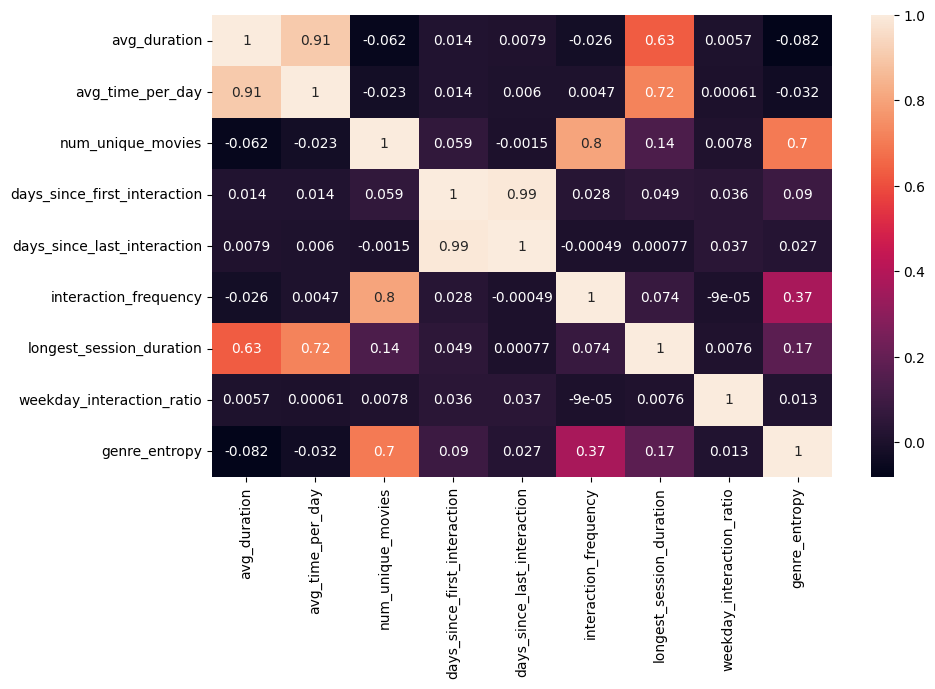

In [48]:
plt.figure(figsize=(10,6))

cor_matrix = features_combined[selected_features].corr()
sns.heatmap(cor_matrix, annot=True)

Using a correlation matrix, columns showing a correlation higher than 70% were identified and removed from the dataset. This process aimed to eliminate redundant information and improve the dataset's efficiency by reducing multicollinearity among features. Consequently, the dataset was refined to exclude columns that exhibited strong correlations, resulting in a more streamlined and potentially more effective set of features for analysis or modeling purposes.

In [49]:
df_corr = features_combined[selected_features]

# Create correlation matrix
corr_matrix = df_corr.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

# Drop features 
df_corr.drop(to_drop, axis=1, inplace=True)

print("Number of remaining columns after eliminated correlated features: ", df_corr.shape[1])

df_kmeans = df_corr.values

Number of remaining columns after eliminated correlated features:  4


1. Elbow Method: Plot the within-cluster sum of squares (WCSS) against different values of K and look for an "elbow" point where the rate of decrease sharply changes. The point where the rate of decrease sharply decreases suggests an optimal number of clusters.

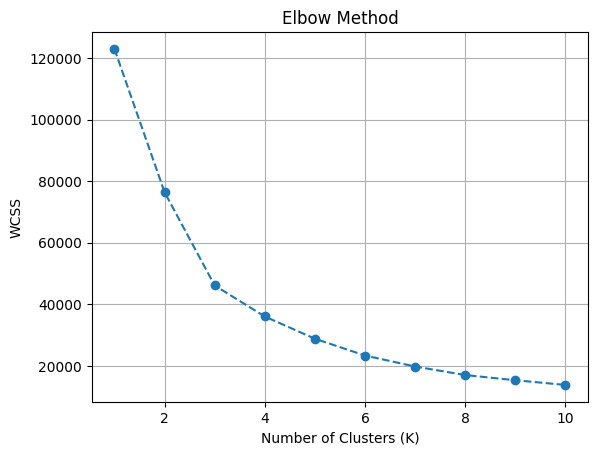

In [50]:
#Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_kmeans)
    wcss.append(kmeans.inertia_)  # inertia_ gives WCSS

plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

2. Silhouette Score: Calculate the silhouette score for different values of K. The silhouette score measures how similar an object is to its own cluster compared to other clusters. Higher silhouette scores indicate better-defined clusters.

In [ ]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_corr)
    silhouette_avg = silhouette_score(df_corr, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

#### KMeans using MapReduce from scratch

In [51]:
# Function to initialize centroids randomly
def initialize_centroids(data, K):
    indices = np.random.choice(data.shape[0], K, replace=False)
    return data[indices]

# Mapper function: Assign each data point to the nearest centroid
def map_function(data_point, centroids):
    distances = np.linalg.norm(data_point - centroids, axis=1)
    nearest_centroid_idx = np.argmin(distances)
    return (nearest_centroid_idx, (data_point, 1))

# Reducer function: Calculate new centroids based on mean of assigned data points
def reduce_function(cluster_id, data_points):
    new_centroid = np.mean([point[0] for point in data_points], axis=0)
    return (cluster_id, new_centroid)

In [52]:
# K-means algorithm
def k_means(data, K, max_iterations=100):
    centroids = initialize_centroids(data, K)

    for _ in range(max_iterations):
        # Map phase
        mapped_data = [map_function(point, centroids) for point in data]

        # Shuffle and sort mapped data by cluster ID
        mapped_data.sort(key=lambda x: x[0])

        # Reduce phase
        reduced_data = {}
        for cluster_id, point_data in mapped_data:
            if cluster_id not in reduced_data:
                reduced_data[cluster_id] = []
            reduced_data[cluster_id].append(point_data)

        new_centroids = [reduce_function(cluster_id, points) for cluster_id, points in reduced_data.items()]
        centroids = np.array([centroid[1] for centroid in new_centroids])

    return centroids

In [53]:
# Decided Number of clusters is 3 from Elbow Method
num_clusters = 3

# Perform K-means clustering
final_centroids_df_kmeans = k_means(df_kmeans, num_clusters)
print("Final centroids:", final_centroids_df_kmeans)

Final centroids: [[0.00296588 0.04907294 0.73885253 0.77594283]
 [0.00294611 0.02202702 0.44313154 0.18759927]
 [0.00284611 0.04128203 0.23275908 0.79981203]]


In [54]:
# Assign cluster labels to each data point manually based on centroids
def assign_cluster_labels(data, centroids):
    distances = np.linalg.norm(data[:, None] - centroids, axis=2)
    cluster_labels = np.argmin(distances, axis=1)
    return cluster_labels

In [55]:
cluster_labels = assign_cluster_labels(df_kmeans, final_centroids_df_kmeans)

# Assign cluster labels to main data
features_combined['cluster_label_df_kmeans'] = cluster_labels

features_combined.cluster_label_df_kmeans.value_counts()

cluster_label_df_kmeans
0    272185
2    241528
1    158023
Name: count, dtype: int64

#### Cluster Statistics

In [56]:
#Cluster 0
features_combined[features_combined['cluster_label_df_kmeans'] == 0].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans
count,2.721850e+05,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.0
mean,1.865655e-03,0.002966,0.003974,0.049073,0.738853,0.710467,0.015799,0.010516,0.775943,0.383971,0.0
std,8.695659e-03,0.008355,0.009228,0.080852,0.145660,0.148157,0.055926,0.022471,0.188225,0.222640,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.476923,0.086813,0.000000,0.000000,0.285714,0.000000,0.0
25%,5.483282e-08,0.000253,0.000403,0.009569,0.609890,0.589011,0.002717,0.000525,0.625000,0.234644,0.0
50%,2.960972e-06,0.001085,0.001774,0.023923,0.737363,0.714286,0.005435,0.004495,0.774194,0.387600,0.0
75%,3.947963e-04,0.002838,0.004075,0.057416,0.863736,0.836264,0.014946,0.011248,1.000000,0.542795,0.0
max,1.000000e+00,1.000000,0.818984,1.000000,1.000000,0.998901,1.000000,1.000000,1.000000,0.981271,0.0


In [57]:
#Cluster 1
features_combined[features_combined['cluster_label_df_kmeans'] == 1].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans
count,1.580230e+05,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.000000,158023.0
mean,1.853218e-03,0.002946,0.004018,0.022027,0.443132,0.428131,0.005982,0.007536,0.187599,0.268600,1.0
std,8.898949e-03,0.009889,0.011249,0.032329,0.257293,0.257801,0.009867,0.016739,0.177983,0.197923,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,5.483282e-08,0.000050,0.000085,0.004785,0.217582,0.204396,0.001359,0.000099,0.000000,0.135427,1.0
50%,5.483282e-08,0.000539,0.000942,0.009569,0.440659,0.434066,0.002717,0.001701,0.200000,0.264578,1.0
75%,3.259811e-04,0.002209,0.003394,0.028708,0.634066,0.621978,0.006793,0.006574,0.333333,0.417325,1.0
max,4.993127e-01,0.793771,0.650086,0.397129,1.000000,1.000000,0.129076,0.499313,0.538462,0.930519,1.0


In [58]:
#Cluster 2
features_combined[features_combined['cluster_label_df_kmeans'] == 2].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans
count,2.415280e+05,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.000000,241528.0
mean,1.790315e-03,0.002846,0.003820,0.041282,0.232759,0.212078,0.012508,0.009021,0.799812,0.344444,2.0
std,8.381230e-03,0.008537,0.010006,0.064370,0.132200,0.134108,0.035867,0.018139,0.182398,0.222875,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.002198,0.000000,0.000000,0.000000,0.388889,0.000000,2.0
25%,5.483282e-08,0.000184,0.000292,0.004785,0.119780,0.103297,0.001359,0.000386,0.655172,0.166930,2.0
50%,6.031610e-07,0.000950,0.001613,0.019139,0.213187,0.198901,0.005435,0.004074,0.800000,0.341612,2.0
75%,3.722600e-04,0.002560,0.003826,0.047847,0.347253,0.318681,0.012228,0.009547,1.000000,0.505295,2.0
max,7.680720e-01,0.610513,1.000000,0.622010,0.495604,0.495604,0.656250,0.768072,1.000000,1.000000,2.0


##### Run the algorithm on the data obtained from the dimensionality reduction

In [59]:
pca_result

array([[ 0.67084436,  0.70524755, -0.36993336,  0.03856856, -0.00146293],
       [ 0.69246205,  0.70077711,  0.06271774, -0.03147976, -0.02371786],
       [ 0.7217946 ,  0.20357278, -0.08293445, -0.01306859, -0.01585846],
       ...,
       [-0.67896941,  0.09408137, -0.00376326, -0.01278159, -0.0109103 ],
       [-0.68973205,  0.39303839,  0.07651497, -0.03364083, -0.00671166],
       [-0.684386  ,  0.22919262,  0.08439762, -0.02506422, -0.00595739]])

In [60]:
# Decided Number of clusters is 3 from Elbow Method
num_clusters = 3

# Perform K-means clustering
final_centroids_pca = k_means(pca_result, num_clusters)
print("Final centroids for pca:", final_centroids_pca)

Final centroids for pca: [[ 3.59384031e-01 -7.94499763e-02  2.56556246e-02 -1.26713196e-04
   5.57075513e-04]
 [-1.11075346e-01  4.97678109e-01 -1.11678538e-01  2.37791504e-03
  -1.27116365e-03]
 [-3.54212832e-01 -1.55331861e-01  2.59472156e-02 -1.03003897e-03
  -6.35462180e-06]]


In [61]:
cluster_labels_pca = assign_cluster_labels(pca_result, final_centroids_pca)

# Assign cluster labels to main data
final_data['cluster_label_pca'] = cluster_labels_pca

final_data.cluster_label_pca.value_counts()

cluster_label_pca
0    290493
2    255213
1    126030
Name: count, dtype: int64

In [62]:
#Cluster 0 for pca data
final_data[final_data['cluster_label_pca'] == 0].describe()

,PC1,PC2,PC3,PC4,PC5,cluster_label_pca
count,290493.000000,290493.000000,290493.000000,290493.000000,290493.000000,290493.0
mean,0.359384,-0.079450,0.025656,-0.000127,0.000557,0.0
std,0.202696,0.211095,0.228918,0.072245,0.033215,0.0
min,-0.018768,-0.354753,-0.383890,-0.052743,-0.137413,0.0
25%,0.183134,-0.305146,-0.125263,-0.027643,-0.011412,0.0
50%,0.361866,-0.086507,0.026731,-0.012227,-0.004082,0.0
75%,0.530241,0.073712,0.181454,0.009131,0.002658,0.0
max,0.772068,0.699448,0.906364,1.191145,0.619356,0.0


In [63]:
#Cluster 1 for pca data
final_data[final_data['cluster_label_pca'] == 1].describe()

,PC1,PC2,PC3,PC4,PC5,cluster_label_pca
count,126030.000000,126030.000000,126030.000000,126030.000000,126030.000000,126030.0
mean,-0.111075,0.497678,-0.111679,0.002378,-0.001271,1.0
std,0.340336,0.170836,0.182728,0.027227,0.016991,0.0
min,-0.737405,0.046936,-0.369933,-0.052968,-0.037390,1.0
25%,-0.398241,0.348163,-0.306526,-0.020712,-0.009534,1.0
50%,-0.098276,0.596341,-0.123956,0.003051,-0.001903,1.0
75%,0.125044,0.643641,0.017107,0.035779,0.001075,1.0
max,0.692462,0.705248,0.650261,0.169625,0.490395,1.0


In [64]:
#Cluster 2 for pca data
final_data[final_data['cluster_label_pca'] == 2].describe()

,PC1,PC2,PC3,PC4,PC5,cluster_label_pca
count,255213.000000,255213.000000,255213.000000,255213.000000,255213.000000,255213.0
mean,-0.354213,-0.155332,0.025947,-0.001030,-0.000006,2.0
std,0.185579,0.199285,0.228530,0.049971,0.022152,0.0
min,-0.709355,-0.406296,-0.348748,-0.055444,-0.106186,2.0
25%,-0.510054,-0.363790,-0.157674,-0.026990,-0.010479,2.0
50%,-0.378754,-0.161633,0.027214,-0.011284,-0.003205,2.0
75%,-0.199110,0.004352,0.185549,0.011268,0.003298,2.0
max,0.027434,0.377105,0.780416,0.720728,0.901618,2.0


### KMeans++ Implementation

In [65]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def kmeans_plusplus(X, k):
    centroids = []
    centroids.append(random.choice(X))

    for _ in range(1, k):
        distances = []
        for x in X:
            dist = min([euclidean_distance(x, c) for c in centroids])
            distances.append(dist)
        next_centroid = X[np.argmax(distances)]
        centroids.append(next_centroid)

    return np.array(centroids)

def kmeans_pp(X, k, max_iters=100):
    centroids = kmeans_plusplus(X, k)
    prev_centroids = np.zeros(centroids.shape)
    clusters = np.zeros(len(X))
    converged = False
    iteration = 0

    while not converged and iteration < max_iters:
        for i in range(len(X)):
            distances = [euclidean_distance(X[i], centroid) for centroid in centroids]
            cluster = np.argmin(distances)
            clusters[i] = cluster

        prev_centroids = np.copy(centroids)

        for i in range(k):
            points = [X[j] for j in range(len(X)) if clusters[j] == i]
            centroids[i] = np.mean(points, axis=0)

        converged = np.array_equal(prev_centroids, centroids)
        iteration += 1

    return clusters, centroids

In [66]:
# Decided Number of clusters is 3 from Elbow Method
num_clusters = 3

result = kmeans_pp(df_kmeans, num_clusters)
clusters = result[0]  # Assigning clusters
final_centroids = result[1]  # Assigning final centroids
print("Final centroids:\n", final_centroids)
print("Assigned clusters:\n", clusters)


Final centroids:
 [[0.0028468  0.04127719 0.23277512 0.79977231]
 [0.00296588 0.04907294 0.73885253 0.77594283]
 [0.00294508 0.02203051 0.44314962 0.187536  ]]
Assigned clusters:
 [2. 2. 1. ... 0. 2. 2.]


In [67]:
features_combined["cluster_label_kmeans++"] = clusters
features_combined["cluster_label_kmeans++"].value_counts()

cluster_label_kmeans++
1.0    272185
0.0    241560
2.0    157991
Name: count, dtype: int64

#### Cluster Statistics for KMeans++

In [69]:
#Cluster 0
features_combined[features_combined['cluster_label_kmeans++'] == 0].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans,cluster_label_kmeans++
count,2.415600e+05,241560.000000,241560.000000,241560.000000,241560.000000,241560.000000,241560.000000,241560.000000,241560.000000,241560.000000,241560.000000,241560.0
mean,1.790748e-03,0.002847,0.003820,0.041277,0.232775,0.212095,0.012507,0.009021,0.799772,0.344420,1.999868,0.0
std,8.382534e-03,0.008539,0.010007,0.064367,0.132199,0.134108,0.035865,0.018139,0.182418,0.222870,0.011509,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.002198,0.000000,0.000000,0.000000,0.388889,0.000000,1.000000,0.0
25%,5.483282e-08,0.000184,0.000291,0.004785,0.119780,0.103297,0.001359,0.000386,0.654545,0.166930,2.000000,0.0
50%,6.031610e-07,0.000949,0.001613,0.019139,0.213187,0.198901,0.005435,0.004074,0.800000,0.341612,2.000000,0.0
75%,3.722600e-04,0.002560,0.003825,0.047847,0.347253,0.318681,0.012228,0.009547,1.000000,0.505295,2.000000,0.0
max,7.680720e-01,0.610513,1.000000,0.622010,0.495604,0.495604,0.656250,0.768072,1.000000,1.000000,2.000000,0.0


In [70]:
#Cluster 1
features_combined[features_combined['cluster_label_kmeans++'] == 1].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans,cluster_label_kmeans++
count,2.721850e+05,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.000000,272185.0,272185.0
mean,1.865655e-03,0.002966,0.003974,0.049073,0.738853,0.710467,0.015799,0.010516,0.775943,0.383971,0.0,1.0
std,8.695659e-03,0.008355,0.009228,0.080852,0.145660,0.148157,0.055926,0.022471,0.188225,0.222640,0.0,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.476923,0.086813,0.000000,0.000000,0.285714,0.000000,0.0,1.0
25%,5.483282e-08,0.000253,0.000403,0.009569,0.609890,0.589011,0.002717,0.000525,0.625000,0.234644,0.0,1.0
50%,2.960972e-06,0.001085,0.001774,0.023923,0.737363,0.714286,0.005435,0.004495,0.774194,0.387600,0.0,1.0
75%,3.947963e-04,0.002838,0.004075,0.057416,0.863736,0.836264,0.014946,0.011248,1.000000,0.542795,0.0,1.0
max,1.000000e+00,1.000000,0.818984,1.000000,1.000000,0.998901,1.000000,1.000000,1.000000,0.981271,0.0,1.0


In [71]:
#Cluster 2
features_combined[features_combined['cluster_label_kmeans++'] == 2].describe()

,duration,avg_duration,avg_time_per_day,num_unique_movies,days_since_first_interaction,days_since_last_interaction,interaction_frequency,longest_session_duration,weekday_interaction_ratio,genre_entropy,cluster_label_df_kmeans,cluster_label_kmeans++
count,1.579910e+05,157991.000000,157991.000000,157991.000000,157991.000000,157991.000000,157991.000000,157991.000000,157991.000000,157991.000000,157991.0,157991.0
mean,1.852569e-03,0.002945,0.004017,0.022031,0.443150,0.428148,0.005983,0.007536,0.187536,0.268621,1.0,2.0
std,8.897178e-03,0.009886,0.011249,0.032332,0.257316,0.257824,0.009868,0.016738,0.177945,0.197938,0.0,0.0
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.0
25%,5.483282e-08,0.000050,0.000085,0.004785,0.217582,0.204396,0.001359,0.000099,0.000000,0.135427,1.0,2.0
50%,5.483282e-08,0.000539,0.000942,0.009569,0.440659,0.434066,0.002717,0.001702,0.200000,0.264578,1.0,2.0
75%,3.259811e-04,0.002209,0.003394,0.028708,0.635165,0.621978,0.006793,0.006574,0.333333,0.417325,1.0,2.0
max,4.993127e-01,0.793771,0.650086,0.397129,1.000000,1.000000,0.129076,0.499313,0.538462,0.930519,1.0,2.0
